# Links
- https://www.discovermagazine.com/planet-earth/what-makes-a-hit-song
- https://www.reddit.com/r/Music/comments/4azwti/what\_makes\_a\_song\_successful/
- https://www8.gsb.columbia.edu/articles/projects/what-makes-a-hit/
- https://songtown.com/really-makes-song-hit/

Dados: https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

In [33]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics import mean_squared_error
%pylab inline

from sklearn.ensemble import RandomForestRegressor
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor


Populating the interactive namespace from numpy and matplotlib


## Começaremos às 20:05
## Quer aprender as melhores práticas na hora de fazer Data Science? Acesse ManualDeDataScience.com

# Carregando os dados

In [34]:
data = pd.read_csv("SpotifyFeatures.csv")
y = data['popularity']

In [35]:
data['track_name'].value_counts()

Home                     100
You                       71
Intro                     69
Stay                      63
Wake Up                   59
                        ... 
Skinny Vegetarian Boy      1
Open Season Is Closed      1
Coge los 4                 1
Thanks for Life            1
Grab Education             1
Name: track_name, Length: 148615, dtype: int64

In [36]:
data.head() ## Essas informações são o bastante? Quais informações você gostaria de ter?

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [37]:
data.isnull().mean()

genre               0.0
artist_name         0.0
track_name          0.0
track_id            0.0
popularity          0.0
acousticness        0.0
danceability        0.0
duration_ms         0.0
energy              0.0
instrumentalness    0.0
key                 0.0
liveness            0.0
loudness            0.0
mode                0.0
speechiness         0.0
tempo               0.0
time_signature      0.0
valence             0.0
dtype: float64

In [38]:
data.groupby("genre")['popularity'].mean().sort_values()

genre
Children's Music     4.252637
A Capella            9.302521
Movie               12.174097
Opera               13.335628
Comedy              21.342630
Anime               24.258729
Ska                 28.612351
Classical           29.282195
Soundtrack          33.954800
Blues               34.742879
World               35.524077
Reggae              35.589328
Reggaeton           37.742915
Electronic          38.056095
Jazz                40.824383
Country             46.100416
Soul                47.027836
Folk                49.940209
Alternative         50.213430
R&B                 52.308719
Children’s Music    54.659040
Indie               54.701561
Dance               57.275256
Hip-Hop             58.423131
Rock                59.619392
Rap                 60.533795
Pop                 66.590667
Name: popularity, dtype: float64

In [39]:
grp_splitter = GroupShuffleSplit(n_splits=1, random_state=0)
rows_train, rows_test = next(grp_splitter.split(data,y,groups=data['track_id']))

Xtrain, Xtest = data.iloc[rows_train].drop('popularity', axis=1), data.iloc[rows_test].drop('popularity', axis=1)
ytrain, ytest = data['popularity'].iloc[rows_train], data['popularity'].iloc[rows_test]

# essa é a validação certa?

# Baseline - quais são boas baselines?

In [40]:
genre_base = data.iloc[rows_train].groupby("genre")['popularity'].mean()
p_base = data.iloc[rows_test]['genre'].map(genre_base)
mean_squared_error(ytest, p_base)

94.45642029514539

In [41]:
artist_base = data.iloc[rows_train].groupby("artist_name")['popularity'].mean()
p_base = data.iloc[rows_test]['genre'].map(artist_base).fillna(ytrain.mean())
mean_squared_error(ytest, p_base)

334.28313875548116

# Rede neural apenas genre e artista

In [8]:
ordinal_encoder = OrdinalEncoder(cols=['genre', 'artist_name'], handle_unknown='return_nan')
Xtrain2 = ordinal_encoder.fit_transform(Xtrain, ytrain)
Xtest2 = ordinal_encoder.transform(Xtest)

Xtest2['genre'] = Xtest2['genre'].fillna(28)
Xtest2['artist_name'] = Xtest2['artist_name'].fillna(13587)

In [9]:
genre_input = layers.Input((1,))
genre_embedding = layers.Embedding(29, 5)(genre_input)
genre_embedding = layers.Flatten()(genre_embedding)

artist_name_input = layers.Input((1,))
artist_name_embedding = layers.Embedding(13588, 5)(artist_name_input)
artist_name_embedding = layers.Flatten()(artist_name_embedding)

concat = layers.concatenate([genre_embedding, artist_name_embedding])
hidden1 = layers.Dense(10, activation='relu')(concat)
drop1 = layers.Dropout(0.5)(hidden1)
out = layers.Dense(1)(hidden1)

In [10]:
mdl = keras.Model([genre_input, artist_name_input], out)
mdl.compile(loss='mse', optimizer='adam')

In [11]:
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         145         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         67940       input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
train_X = [Xtrain2[['genre']].values, Xtrain2[['artist_name']].values]
test_X = [Xtest2[['genre']].values, Xtest2[['artist_name']].values]


mdl.fit(train_X, ytrain.values, validation_data=[test_X, ytest.values], batch_size=64, epochs=5) #early stopping

Train on 186358 samples, validate on 46367 samples
Epoch 1/5
186358/186358 [==============================] - 10s 52us/sample - loss: 284.2109 - val_loss: 73.1741
Epoch 2/5
186358/186358 [==============================] - 9s 48us/sample - loss: 66.4443 - val_loss: 71.4016
Epoch 3/5
186358/186358 [==============================] - 8s 45us/sample - loss: 64.5219 - val_loss: 70.9826
Epoch 4/5
186358/186358 [==============================] - 9s 46us/sample - loss: 63.7207 - val_loss: 70.8494
Epoch 5/5
186358/186358 [==============================] - 8s 42us/sample - loss: 63.2495 - val_loss: 70.8426


# Rede neural + features numéricas

In [77]:
Xtrain2_num = Xtrain.select_dtypes(include=np.number)
Xtest2_num = Xtest.select_dtypes(include=np.number)

scaler = StandardScaler()
Xtrain2_num = scaler.fit_transform(Xtrain2_num)
Xtest2_num = scaler.transform(Xtest2_num)

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [76]:
Xtrain2_num.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
1,0.24600,0.590,137373,0.7370,0.00000,0.1510,-5.559,0.0868,174.003,0.816
5,0.74900,0.578,160627,0.0948,0.00000,0.1070,-14.970,0.1430,87.479,0.358
6,0.34400,0.703,212293,0.2700,0.00000,0.1050,-12.675,0.9530,82.873,0.533
7,0.93900,0.416,240067,0.2690,0.00000,0.1130,-8.949,0.0286,96.827,0.274
8,0.00104,0.734,226200,0.4810,0.00086,0.0765,-7.725,0.0460,125.080,0.765


In [14]:
genre_input = layers.Input((1,))
genre_embedding = layers.Embedding(29, 5)(genre_input)
genre_embedding = layers.Flatten()(genre_embedding)

artist_name_input = layers.Input((1,))
artist_name_embedding = layers.Embedding(13588, 5)(artist_name_input)
artist_name_embedding = layers.Flatten()(artist_name_embedding)

nums = layers.Input((Xtrain2_num.shape[1],))

concat = layers.concatenate([genre_embedding, artist_name_embedding, nums])
hidden1 = layers.Dense(10)(concat)
drop1 = layers.Dropout(0.5)(hidden1)
out = layers.Dense(1)(hidden1)

In [15]:
mdl = keras.Model([genre_input, artist_name_input, nums], out)
mdl.compile(loss='mse', optimizer='adam')

In [16]:
train_X = [Xtrain2[['genre']].values, Xtrain2[['artist_name']].values, Xtrain2_num]
test_X = [Xtest2[['genre']].values, Xtest2[['artist_name']].values, Xtest2_num]


mdl.fit(train_X, ytrain.values, validation_data=[test_X, ytest.values], batch_size=64, epochs=5)

Train on 186358 samples, validate on 46367 samples
Epoch 1/5
186358/186358 [==============================] - 9s 50us/sample - loss: 292.1949 - val_loss: 72.8040
Epoch 2/5
186358/186358 [==============================] - 9s 46us/sample - loss: 66.1048 - val_loss: 71.1506
Epoch 3/5
186358/186358 [==============================] - 8s 43us/sample - loss: 63.9701 - val_loss: 70.3744
Epoch 4/5
186358/186358 [==============================] - 8s 44us/sample - loss: 63.1653 - val_loss: 70.6993
Epoch 5/5
186358/186358 [==============================] - 9s 49us/sample - loss: 62.7259 - val_loss: 70.6039


In [42]:
target_encoder = TargetEncoder(cols=['genre', 'artist_name'], handle_unknown='value')
Xtrain3 = target_encoder.fit_transform(Xtrain, ytrain).select_dtypes(include=np.number)
Xtest3 = target_encoder.transform(Xtest).select_dtypes(include=np.number)

In [43]:
mdl = LGBMRegressor(random_state=0, verbose=0)
mdl.fit(Xtrain3, ytrain)
p = mdl.predict(Xtest3)

mean_squared_error(ytest, p)

70.1271623018662

In [14]:
mdl = RandomForestRegressor(random_state=0, n_jobs=6, n_estimators=100)
mdl.fit(Xtrain3, ytrain)
p = mdl.predict(Xtest3)

mean_squared_error(ytest, p)

69.06589632884018

In [16]:
Xtrain4 = Xtrain[Xtrain3.columns]
Xtest4 = Xtest[Xtrain3.columns]

In [17]:
mdl = CatBoostRegressor(random_state=0, verbose=0, cat_features=['genre', 'artist_name'])
mdl.fit(Xtrain4, ytrain)
p = mdl.predict(Xtest4)

mean_squared_error(ytest, p)

75.56348731270667

# SHAP

In [46]:
%%time
import shap

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtrain3)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 2min 50s, sys: 578 ms, total: 2min 50s
Wall time: 15.3 s


In [47]:
Xtrain3.columns

Index(['genre', 'artist_name', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence'],
      dtype='object')

In [63]:
?shap.summary_plot

Signature:
shap.summary_plot(
    shap_values,
    features=None,
    feature_names=None,
    max_display=None,
    plot_type=None,
    color=None,
    axis_color='#333333',
    title=None,
    alpha=1,
    show=True,
    sort=True,
    color_bar=True,
    plot_size='auto',
    layered_violin_max_num_bins=20,
    class_names=None,
    class_inds=None,
    color_bar_label='Feature value',
    auto_size_plot=None,
)
Docstring:
Create a SHAP summary plot, colored by feature values when they are provided.

Parameters
----------
shap_values : numpy.array
    For single output explanations this is a matrix of SHAP values (# samples x # features).
    For multi-output explanations this is a list of such matrices of SHAP values.

features : numpy.array or pandas.DataFrame or list
    Matrix of feature values (# samples x # features) or a feature_names list as shorthand

feature_names : list
    Names of the features (length # features)

max_display : int
    How many top features to include in

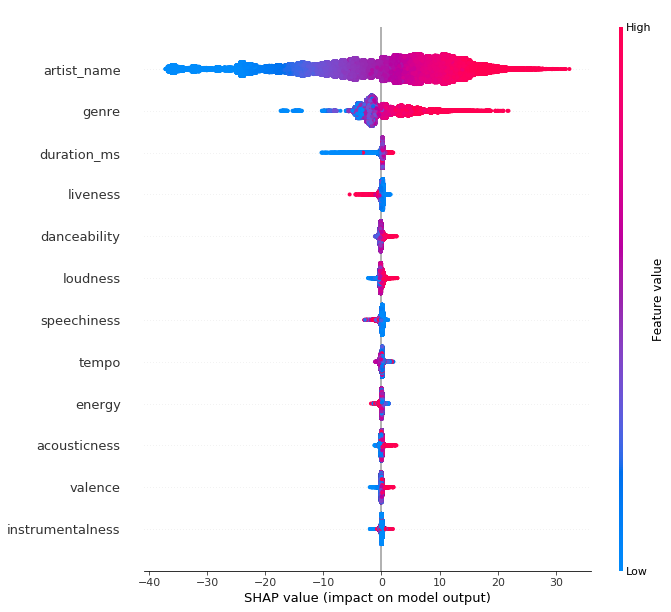

In [65]:
shap.summary_plot(shap_values, Xtrain3, plot_size=(10,10))

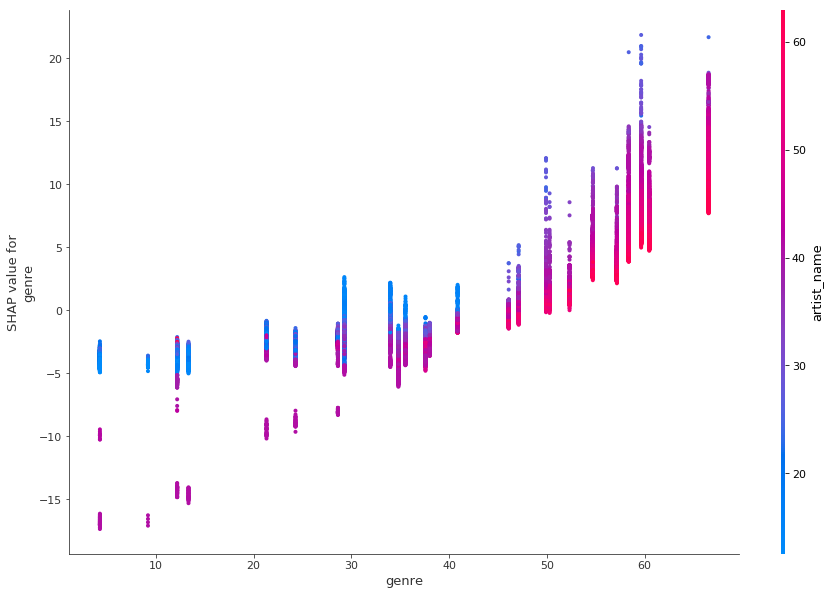

In [66]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
shap.dependence_plot("genre", shap_values, Xtrain3, ax=ax) # o que tem de "errado" nesse gráfico?

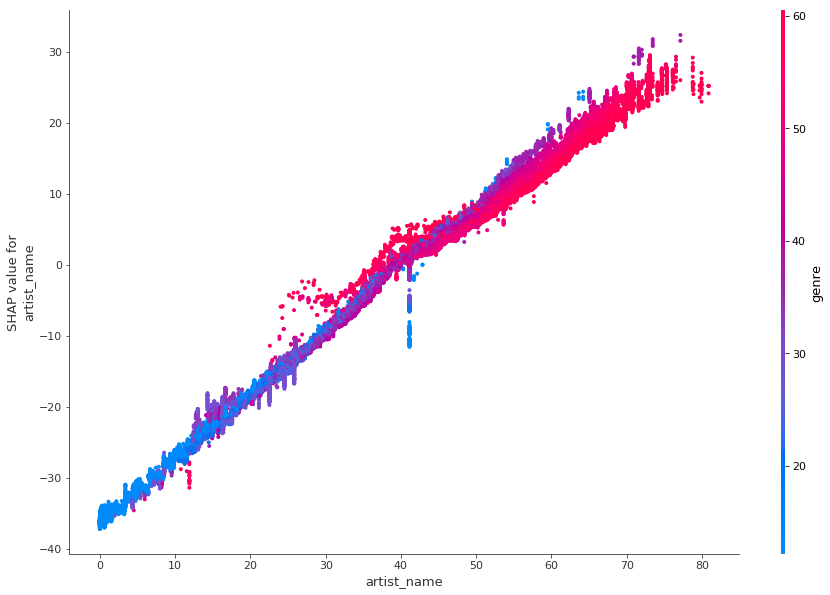

In [67]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
shap.dependence_plot("artist_name", shap_values, Xtrain3, ax=ax)

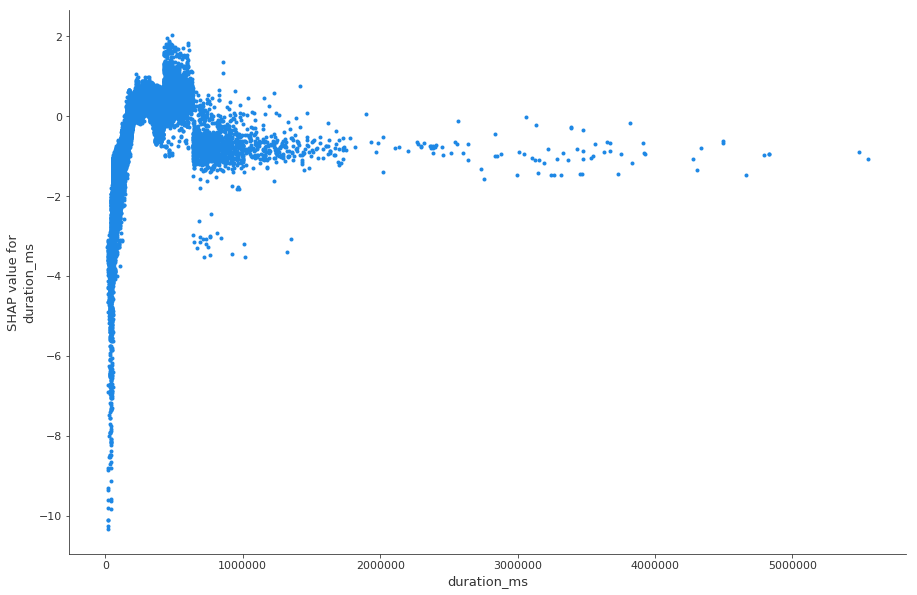

In [69]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
shap.dependence_plot("duration_ms", shap_values, Xtrain3, ax=ax, interaction_index=None)

## Conclusões

- Talvez a questão certa não seja: qual música será sucesso? Mas: qual música, se interpretada por este artista, será um sucesso?
    - Como isso seria usado em produção?
   
- A mesma música, em genre diferente, possui popularidade diferente, por isso que genre é importante

- A popularidade é “todos contra todos”, talvez fosse mais adequado ter popularidade “intra genre”

- Qual o “efeito psicológico” dessa música? Que emoções essa música causa?

- Música instrumental tem bem menos sucesso. As letras influenciam?

- "Ação" por parte do ouvinte - "Having a dance to go with your song" -> Funk

- Verba de marketing e "momento" em que a música é lançada fazem diferença

- Músicas de sucesso tendem a ser uma versão modificada do que é sucesso no momento

- A successful song... Originality: 10% Sonic makeup: 20% Melody: 30% Marketing: 40%

- "So what would have happened if a no-name act wrote and recorded “Hey Jude” in 1968? ... but given the factors governing what makes a song a hit, it’s unlikely it would be as big a hit as it was when played by The Beatles’."